# RQ2 additional results

But software performances are influenced by the configuration options e.g. the energy consumption. 
An option is called influential for a performance when its values have a strong effect on this performance. 
For example, developers might wonder whether the option they add to a configurable software has an influence on its performance.
However, is an option identified as influential for some inputs still influential for other inputs?
If not, it would become both tedious and time-consuming to find influential options on a per-input basis. 
Besides, it is unclear if activating an option is always worth it in terms of performance; an option could improve the overall performance but reduce it for few inputs. 
If so, users may wonder which options to enable to improve software performances based on their input data. 

In order to understand how a performance model can change based on a given input, we next study how input data interact with configuration options. 

## RQ2 - Do configuration option’s effects change with input data?


To assess the relative importances and effects of options, we use two well-known statistical methods. 


**Random Forest Importances.** The tree structure provides insights about the most essential options for prediction as a tree splits first options that provide the highest information gain. 
We use random forests (a vote between multiple decision trees):
we can derive, from the forests trained on the inputs, estimates of the options importance. 
The computation of option importance is realized through the observation of the eﬀect on random forest accuracy of randomly shuffling each predictor variable.
For a random forest, we consider that an option is influential if its option importance (i.e. median on all inputs) is greater than $\frac{1}{n_{opt}}$, where $n_{opt}$ is the number of options considered in the dataset. 
This threshold represents the theoretic importance of options for a software having equally important options (inspired by the Kaiser rule). 


**Linear Regression Coefficients.** The coefficients of an Ordinary Least Square (OLS) regression weight the effect of configuration options. 
These coefficients can be positive (resp. negative) if a bigger (resp. lower) option value results in a bigger performance. 
Ideally, the sign of the coefficients of a given option should remain the same for all inputs: it would suggest that the effect of an option onto performance is stableWe also provide details about coefficients related to the interactions of options (i.e. feature interactions).


## In this notebook, we compute a variant of impurity-based feature importance, called the feature permutation importance

#### First, we import some libraries

In [4]:
# for arrays
import numpy as np

# for dataframes
import pandas as pd

# plots
import matplotlib.pyplot as plt
# high-level plots
import seaborn as sns

# statistics
import scipy.stats as sc
# hierarchical clustering, clusters
from scipy.cluster.hierarchy import linkage, cut_tree, leaves_list
from scipy import stats
# statistical tests
from scipy.stats import mannwhitneyu

# machine learning library
# Principal Component Analysis - determine new axis for representing data
from sklearn.decomposition import PCA
# Random Forests -> vote between decision trees
# Gradient boosting -> instead of a vote, upgrade the same tree
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier, GradientBoostingClassifier
# Decision Tree
from sklearn.tree import DecisionTreeRegressor, plot_tree
# To add interactions of features in linear regressions models
from sklearn.preprocessing import PolynomialFeatures
# Elasticnet is an hybrid method between ridge and Lasso
from sklearn.linear_model import LinearRegression, ElasticNet
# To separate the data into training and test
from sklearn.model_selection import train_test_split
# Simple clustering (iterative steps)
from sklearn.cluster import KMeans
# feature permutation importance
from sklearn.inspection import permutation_importance

# we use it to interact with the file system
import os
# compute time
from time import time

# statistics
import scipy.stats as sc
# hierarchical clustering, clusters
from scipy.cluster.hierarchy import linkage, cut_tree, leaves_list
from scipy import stats
# statistical tests
from scipy.stats import mannwhitneyu

# no warning
import warnings
warnings.filterwarnings("ignore")

### Import data

In [2]:
data_dir = "../../../data/"
name_systems = ["nodejs", "poppler", "xz", "x264", "gcc", "lingeling", "sqlite", "imagemagick"]

data = dict()
inputs_name = dict()
inputs_count = dict()
inputs_perf = dict()

inputs_perf["gcc"] = ["size", "ctime", "exec"]
inputs_perf["imagemagick"] = ["size", "time"]
inputs_perf["lingeling"] = ["conflicts", "cps", "reductions"]
inputs_perf["nodejs"] = ["ops"]
inputs_perf["poppler"] = ["size", "time"]
inputs_perf["sqlite"] = ["q"+str(i+1) for i in range(15)]
inputs_perf["x264"] = ["size", "kbs", "fps", "etime", "cpu"]
inputs_perf["xz"] = ["size", "time"]


inputs_feat = dict()

inputs_feat["gcc"] = ["optim","-floop-interchange","-fprefetch-loop-arrays","-ffloat-store","-fno-asm"]
inputs_feat["imagemagick"] = ["memory_r", "posterize_r", "gaussian-blur", "thread", "quality"]
inputs_feat["lingeling"] = ["--boost", "--carduse", "--decompose", "--gluescale", "--lkhd", "--memlim", 
"--minimize", "--prbsimple", "--sweepirr", "--sweepred"]
inputs_feat["nodejs"] = ["--jitless", "--experimental-wasm-modules", "--experimental-vm-modules",
                         "--preserve-symlinks-main","--no-warnings","--node-memory-debug"]
inputs_feat["poppler"] = ["format","j","jp2","jbig2","ccitt"]
inputs_feat["sqlite"] = ["-deserialize", "-memtrace", "-maxsize", "-append", "-output"]
inputs_feat["x264"] = ["cabac", "ref", "deblock", "analyse", "me", "subme", "mixed_ref", "me_range", "trellis", 
                "8x8dct", "fast_pskip", "chroma_qp_offset", "bframes", "b_pyramid", "b_adapt", "direct", 
                "weightb", "open_gop", "weightp", "scenecut", "rc_lookahead", "mbtree", "qpmax", "aq-mode"]
inputs_feat["xz"] = ["memory","format","level","depth"]


inputs_categ = dict()

inputs_categ["gcc"] = ["optim"]
inputs_categ["imagemagick"] = []
inputs_categ["lingeling"] = []
inputs_categ["nodejs"] = []
inputs_categ["poppler"] = ["format"]
inputs_categ["sqlite"] = []
inputs_categ["x264"] = ['analyse', 'me', 'direct', 'deblock']
inputs_categ["xz"] = ['memory', 'format']


for ns in name_systems:
    
    data_path = data_dir+ns+'/'
    
    inputs = sorted(os.listdir(data_path))
    inputs.remove('others')

    inputs_name[ns] = inputs
    inputs_count[ns] = len(inputs)
    
    for i in range(len(inputs)):
        loc = data_path+inputs[i]
        data[ns, i] = pd.read_csv(loc)

# RQ2 code

## Compute importances

In [19]:
def compute_importances(ns, dim):
    # input : a list of videos
    # output : a dataframe of feature importances
    
    # the final list of importances
    listImportances = []
    
    features = inputs_feat[ns]
    to_keep = [f for f in features]
    to_keep.append(dim)
    categorial = inputs_categ[ns]

    # for each video of the list
    for id_input in range(inputs_count[ns]):
        
        # we replace missing numbers by 0
        df = data[ns, id_input][to_keep]
        
        df = df.replace(to_replace = "None", value = '0')
        
        # standardization
        for col in features:
            # we center and reduce the quantitative variables
            # i.e substract the mean, and divide by the standard deviation
            # to avoid the scale of the vars to interfere with the learning process
            if col not in categorial:
                arr_col = np.array(df[col], float)
                arr_col = (arr_col-np.mean(arr_col))/(np.std(arr_col)+1e-5)
                df[col] = arr_col
            else:
                # if the variable is categorial
                df[col] = [np.where(k==df[col].unique())[0][0] for k in df[col]]
                arr_col = np.array(df[col], float)
                arr_col = (arr_col-np.mean(arr_col))/(np.std(arr_col)+1e-5)
                df[col] = arr_col
        
        # for each video, we train a model
        clf = RandomForestRegressor(n_estimators=20)
        # we use all the configuration options as predicting variables
        X = df.drop([dim], axis=1)
        # and the bitrate distribution of the video as a variable to predict
        y = df[dim]
        # we train the model on all the data (not train-test since we don't use the model)
        clf.fit(X, y)
        
        # we add feature importances to the list
        listImportances.append(permutation_importance(clf, X, y, n_repeats=10)['importances_mean'])
    
    print(listImportances[0])
    # final dataframe of feature importances
    res = pd.DataFrame({'features' : features})
    
    # significative numbers p, cs = 10^p
    cs = 100
    
    # we add the feature imps to the dataframe 
    for id_input in range(len(listImportances)):
        res['video_'+str(id_input)] = np.round(cs*listImportances[id_input])/cs
    
    # transpose it
    res = res.set_index('features').transpose()
    
    # return it 
    return res

## Compute effects

In [20]:
def compute_coefs(ns, dim):
    # input : a list of videos
    # output : a dataframe of feature importances
    
    # the final list of coefficients
    listCoefs = []
    
    features = inputs_feat[ns]
    to_keep = [f for f in features]
    to_keep.append(dim)
    categorial = inputs_categ[ns]

    # for each video of the list
    for id_input in range(inputs_count[ns]):
        
        # we replace missing numbers by 0
        df = data[ns, id_input][to_keep]
        
        df = df.replace(to_replace = "NaN", value = '0')
        df = df.replace(to_replace = "None", value = '0')

        # standardization
        for col in to_keep:
            # we center and reduce the quantitative variables
            # i.e substract the mean, and divide by the standard deviation
            # to avoid the scale of the vars to interfere with the learning process
            if col not in categorial:
                arr_col = np.array(df[col], float)
                arr_col = (arr_col-np.mean(arr_col))/(np.std(arr_col)+1e-5)
                df[col] = arr_col
            else:
                # if the variable is categorial
                df[col] = [np.where(k==df[col].unique())[0][0] for k in df[col]]
                arr_col = np.array(df[col], float)
                arr_col = (arr_col-np.mean(arr_col))/(np.std(arr_col)+1e-5)
                df[col] = arr_col

        # for each video, we train a model
        indexes = np.array([k for k in range(len(df[dim])) 
                            if df[dim][k] != float("inf") and not np.isnan(df[dim][k])],int)
        lr = LinearRegression()
        # we use all the configuration options as predicting variables
        X = df.drop([dim], axis=1)
        # and the bitrate distribution of the video as a variable to predict
        y = [float(k) for k in df[dim]]
        #print(y)
        # we train the model on all the data (not train-test since we don't use the model)
        lr.fit(X, y)
        # we add feature importances to the list
        listCoefs.append(lr.coef_)
    
    # final dataframe of feature importances
    res = pd.DataFrame({'features' : features})
    
    # significative numbers p, cs = 10^p
    cs = 100
    
    # we add the feature imps to the dataframe 
    for id_input in range(len(listCoefs)):
        res['video_'+str(id_input)] = np.round(cs*listCoefs[id_input])/cs
    
    # transpose it
    res = res.set_index('features').transpose()
    
    # return it 
    return res

## Show the boxplot of effects and importances

In [21]:
def boxplot_imp(ns, dim, xlim = None, xname='Importances'):
    ### in: 
    #### ns the name of the system
    #### dim the name of the current performance property
    #### xlim limits if needed to focus on the important part of the chart
    #### xname the name of the abcissae and if we compute the importances or the effects
    ### out :
    #### a boxplot (saved in the system file)
    
    if xname == 'Importances':
        res = compute_importances(ns, dim)
    else:
        res = compute_coefs(ns, dim)
    
    # sort by names
    listImp = [(np.abs(np.percentile(res[col],75)-np.percentile(res[col],25)),res[col], col) 
               for col in res.columns]
    listImp.sort(key=lambda tup: tup[2], reverse=True)

    # see figures 2a and 2b
    red_square = dict(markerfacecolor='r', marker='s')
    plt.figure(figsize=(15,8))
    plt.grid()
    plt.boxplot([l[1] for l in listImp], flierprops=red_square, 
              vert=False, patch_artist=True, #widths=0.25,
              boxprops=dict(facecolor=(0,0,1,0.5),linewidth=1,edgecolor='k'),
              whiskerprops = dict(linestyle='-.',linewidth=1.0, color='black'))
    plt.xlabel(xname, size=13)
    if xlim:
        plt.xlim(xlim)
    plt.yticks(range(1, len(listImp) + 1), [l[2] for l in listImp])
    if xname == 'Importances':
        plt.savefig("../../../results/systems/"+ns+"/"+"boxplot_imp_"+dim+".png")
    else:
        plt.savefig("../../../results/systems/"+ns+"/"+"boxplot_effect_"+dim+".png")
    plt.show()

# RQ2 results for each system

### GCC

#### compilation time

[1.7229764  0.01903863 0.3463261  0.07321026 0.02476009]


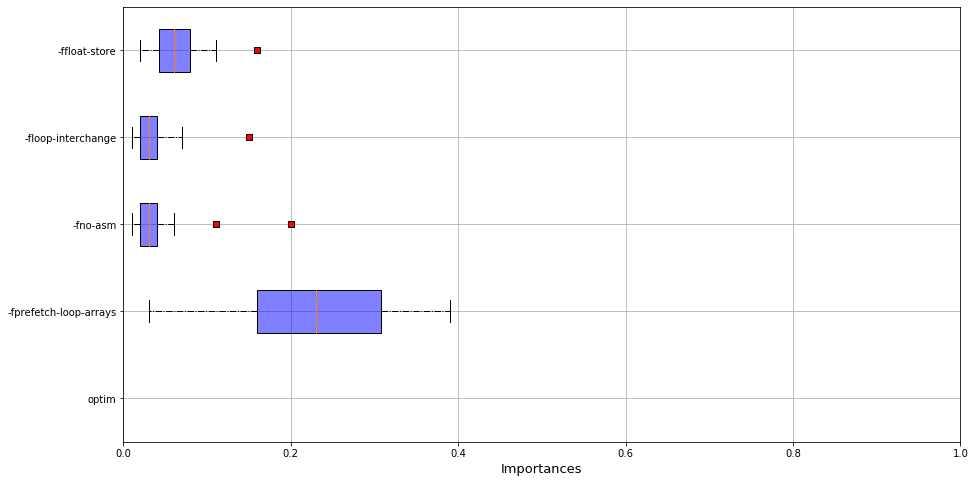

In [23]:
boxplot_imp("gcc", "ctime", xlim =[0,1], xname='Importances')

Overall, for the compilation time of gcc, there is one influential options, namely `optim` i.e., the flag -Og -O1 -O2 -O3 -Ofast

Apart from one single value, this option is always negatively related to the time; without much surprise, activating -Ofast decreases the compile time of the program.

#### execution time

[1.39284151 0.02012122 0.02925668 0.57182954 0.01153129]


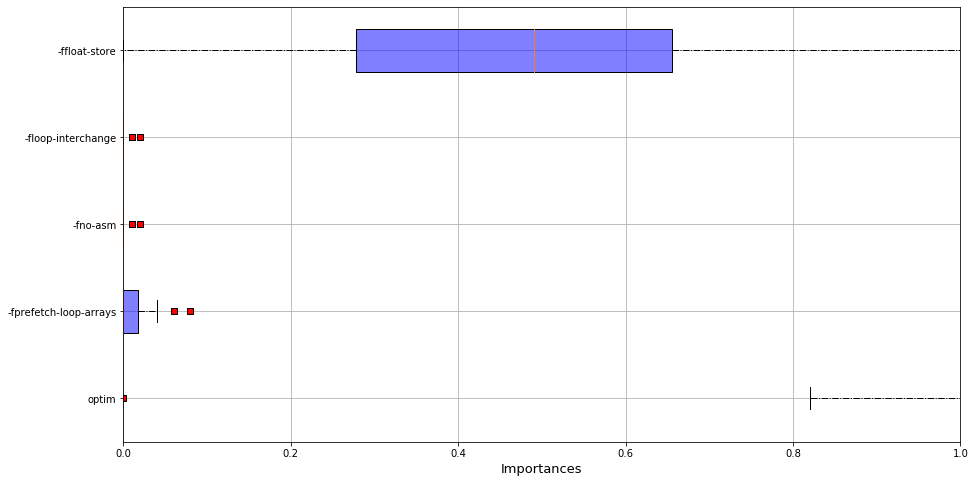

In [25]:
boxplot_imp("gcc", "exec", xlim =[0,1], xname='Importances')

Overall, for the execution time of gcc, there is two influential options, namely `optim` i.e., the flag -Og -O1 -O2 -O3 -Ofast and `-ffloat-store`

#### size

[ 1.00517906e+00  5.42362040e-04  8.74421709e-01  9.36475663e-01
 -5.97745461e-04]


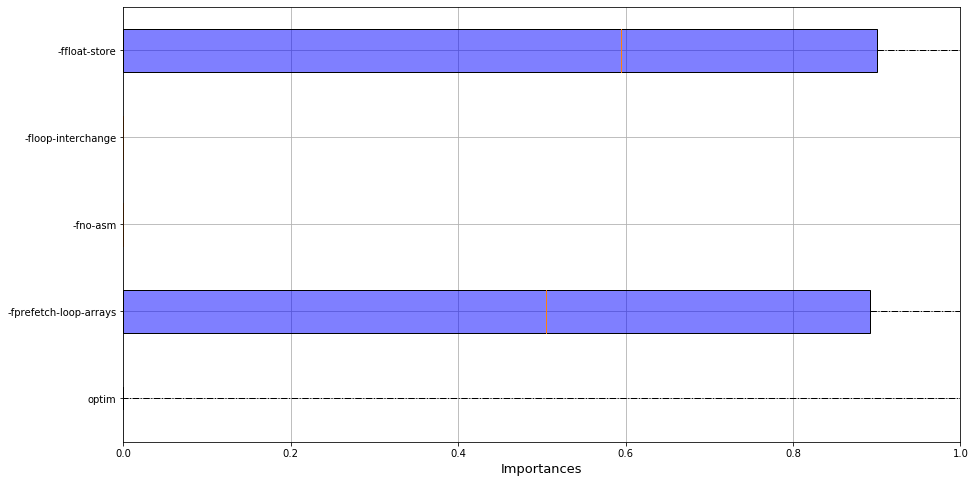

In [26]:
boxplot_imp("gcc", "size", xlim =[0,1], xname='Importances')

For the binary size, it is a very interesting result; there is nothing wrong with the boxplots of the upper charts, there is only one value for each, so we are not able to see them.

As presented in the paper, this is our textbook case of a stable software system (in our experiment) w.r.t. the input sensitivity.

### Imagemagick

#### time

[0.47760102 0.50850892 0.34695187 0.563415   0.43841958]


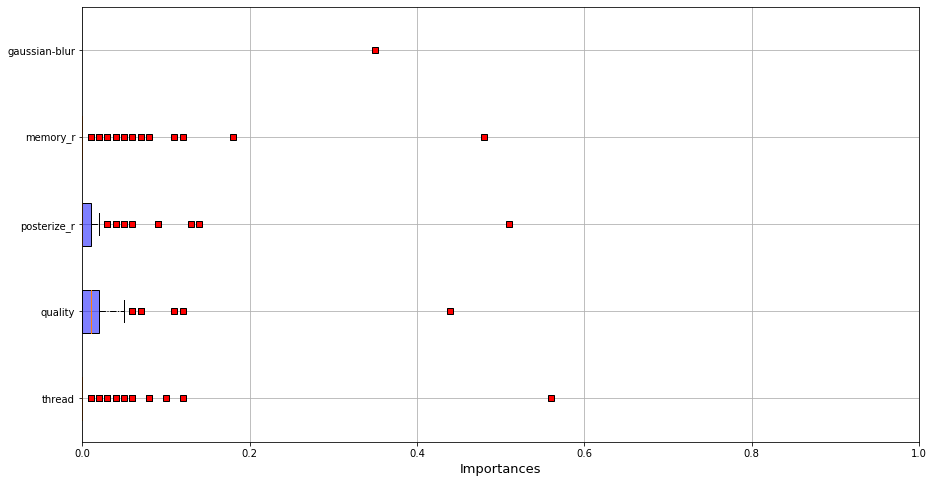

In [27]:
boxplot_imp("imagemagick", "time", xlim =[0,1], xname='Importances')

### Lingeling

#### conflicts

[0.32665613 0.41761367 0.07308247 0.10008536 0.28110569 0.04672986
 0.12278326 0.17684608 0.45008101 0.09855605]


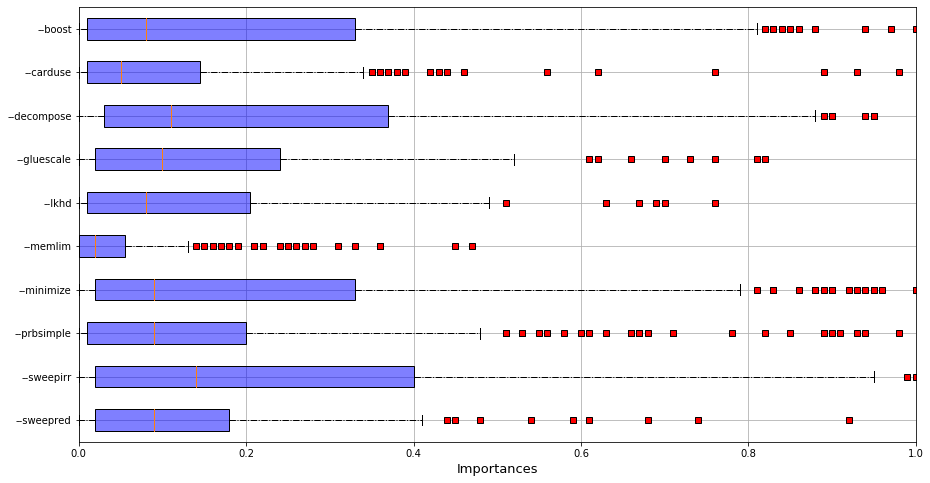

In [28]:
boxplot_imp("lingeling", "conflicts", xlim =[0,1], xname='Importances')

For lingeling, to contrast with gcc, there are lots of variations depending on the SAT formula processed by the software. 

There are many corner cases, for which an option becomes suddently influential.

Most options can have positive and negative effects depending on inputs.

#### conflicts per second

[0.48462902 0.25975581 0.18766914 0.32530939 0.60134399 0.03479566
 0.00483057 0.22851694 0.17654686 0.14184268]


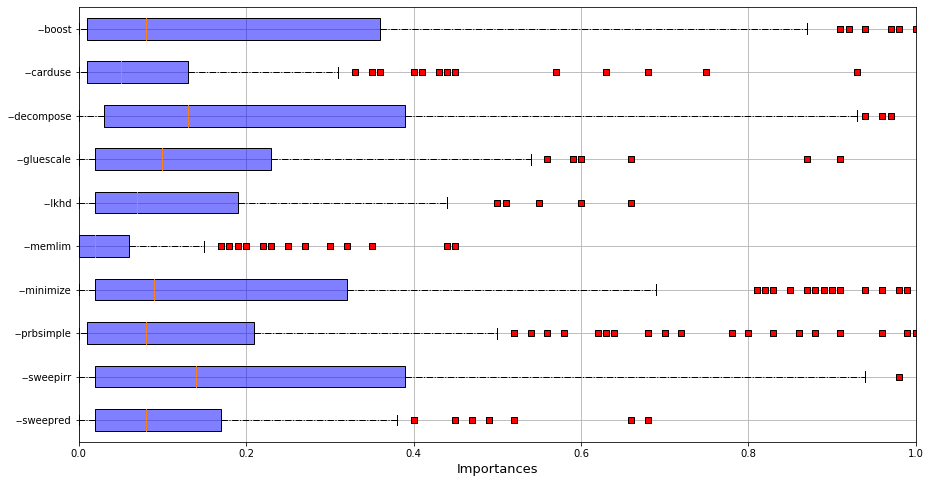

In [29]:
boxplot_imp("lingeling", "cps", xlim =[0,1], xname='Importances')

Same conclusion as for the conflicts performance property.

#### reductions

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


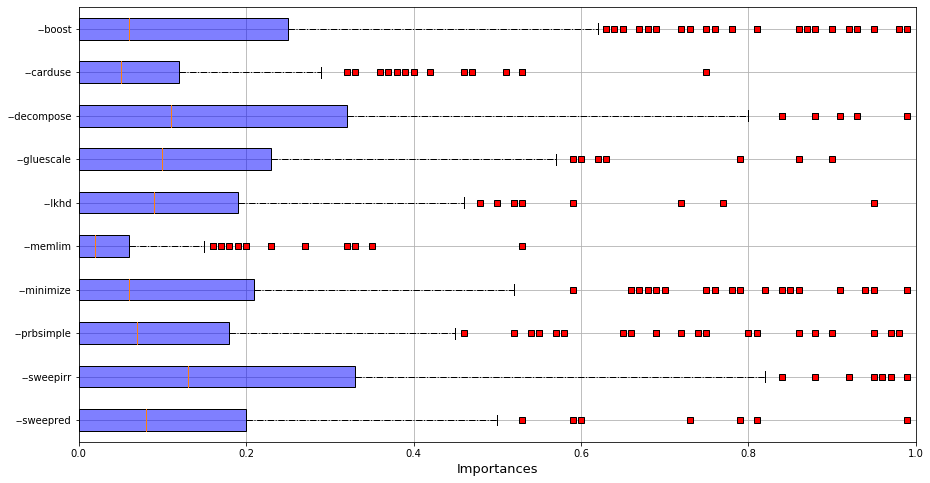

In [30]:
boxplot_imp("lingeling", "reductions", xlim =[0,1], xname='Importances')

Again, all the options might be influential at some point, for few inputs.

An expertise of the domain could help to understand the link between the content of these formulae and the way it is processed by the software i.e. how it interacts with configuration options. 

### NodeJS

#### number of operations per second

[2.03553772 0.0211522  0.02518601 0.0296024  0.01916781 0.03373892]


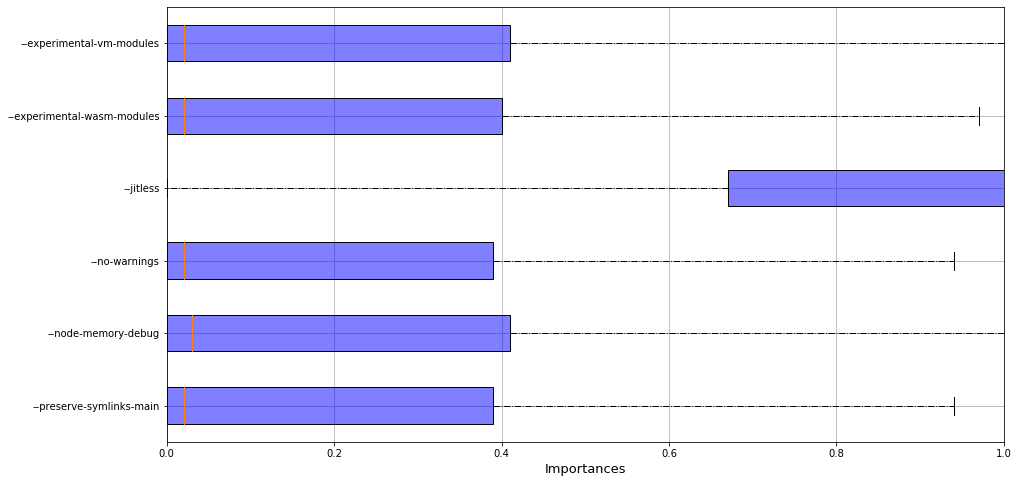

In [31]:
boxplot_imp("nodejs", "ops", xlim =[0,1], xname='Importances')

For nodeJS, the `jitless` option is definitely the most influential across inputs.

In general, activating it will reduce the number of operations computed by the input (java)scripts. But there are few exceptions.

The other configuration option to watch is the `node-memory-debug` feature; for few inputs, it can have a greater influence than `jitless`.

### Poppler

#### size

[0. 0. 0. 0. 0.]


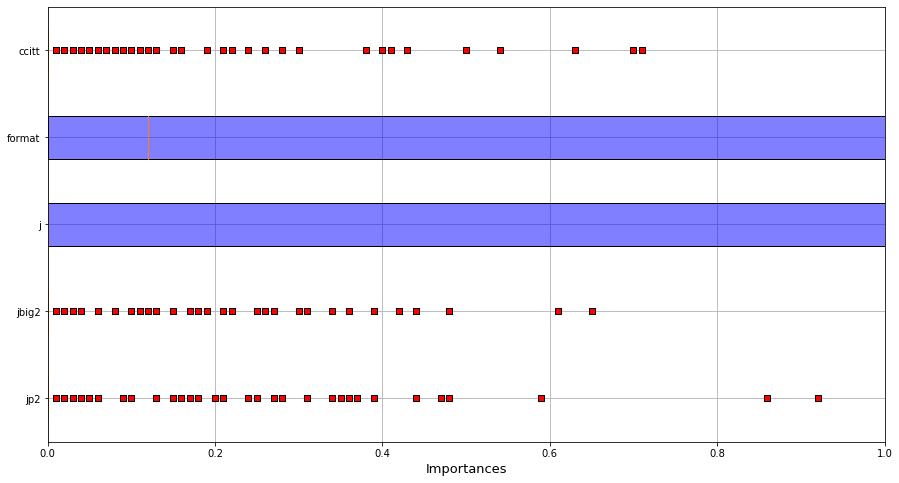

In [32]:
boxplot_imp("poppler", "size", xlim =[0,1], xname='Importances')

The size of the output directory containing the images extracted from the pdfs is naturally highly dependent of the format of the output image (e.g. jpg, png, etc.).

But using a library to handle jpegs files can interact with the influential options for few inputs.

Again, this is a case where : (1) there is a general trend for the influential options but (2) for some inputs, it does not respect the rule.

It can be interesting to detect a priori the second cases (2) thanks to machine learning, so we can predict performances whatever the input. 

#### time

[0.47441194 1.02644947 0.73361809 0.52592262 0.01033688]


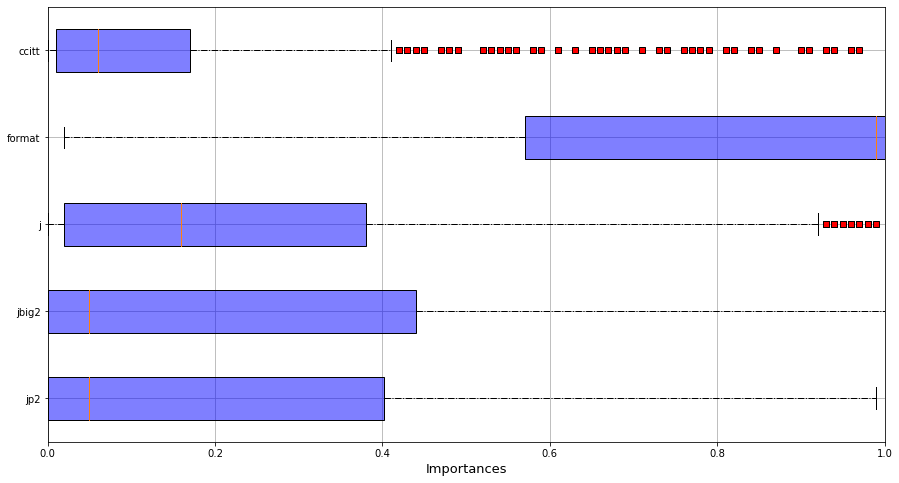

In [33]:
boxplot_imp("poppler", "time", xlim =[0,1], xname='Importances')

Here, there is a compromise to find for the value of `format` between the time and the size, since activating `format` decreases the size, but increases the time.

And this value may depend on input data; we have to adapt the predictive model.

### SQLite

#### q1

[0.23936534 1.17382286 0.         0.18688241 0.        ]


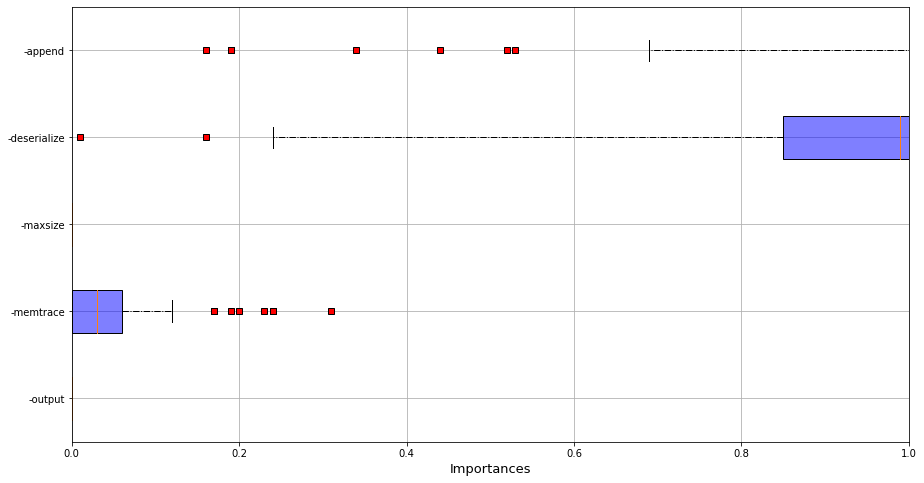

In [34]:
boxplot_imp("sqlite", "q1", xlim =[0,1], xname='Importances')

#### q2

[0.43554113 0.9201887  0.         0.27786583 0.        ]


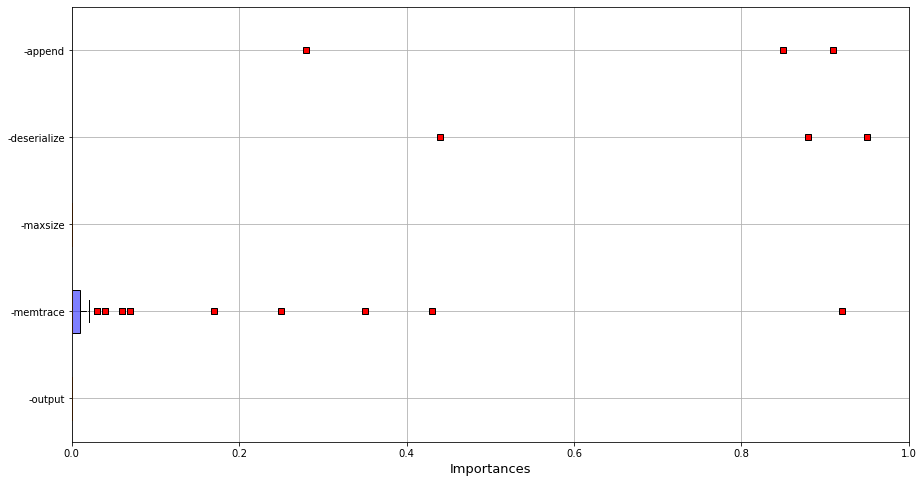

In [35]:
boxplot_imp("sqlite", "q2", xlim =[0,1], xname='Importances')

#### q3

[0.30375955 0.87009852 0.         0.26735529 0.        ]


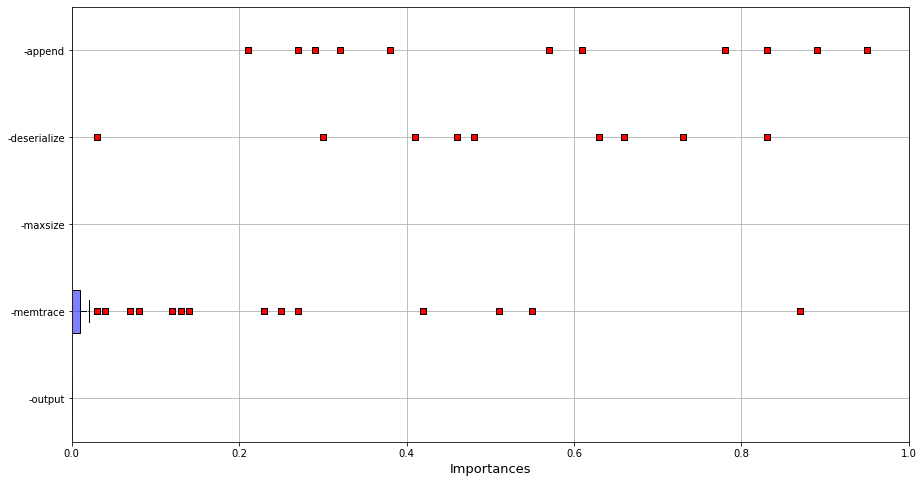

In [36]:
boxplot_imp("sqlite", "q3", xlim =[0,1], xname='Importances')

#### q4

[0.51470819 0.96392125 0.         0.28816617 0.        ]


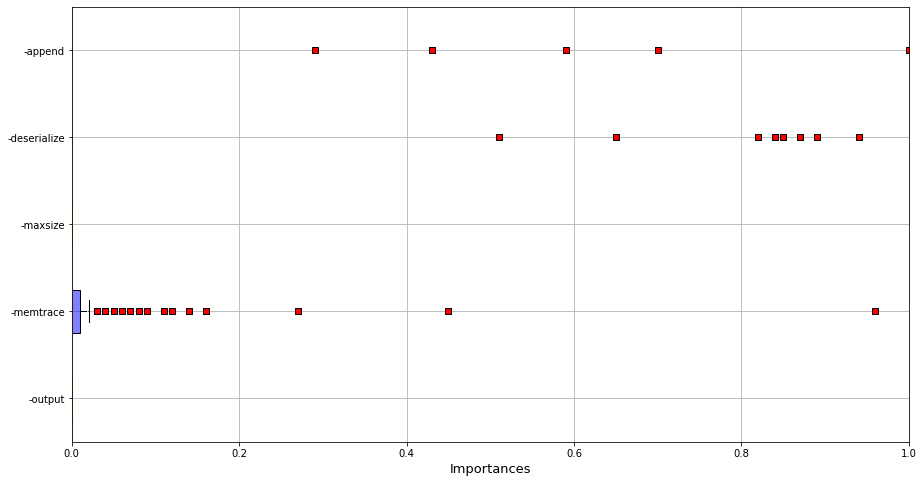

In [37]:
boxplot_imp("sqlite", "q4", xlim =[0,1], xname='Importances')

#### q5

[0.47287036 0.97792572 0.         0.29962141 0.        ]


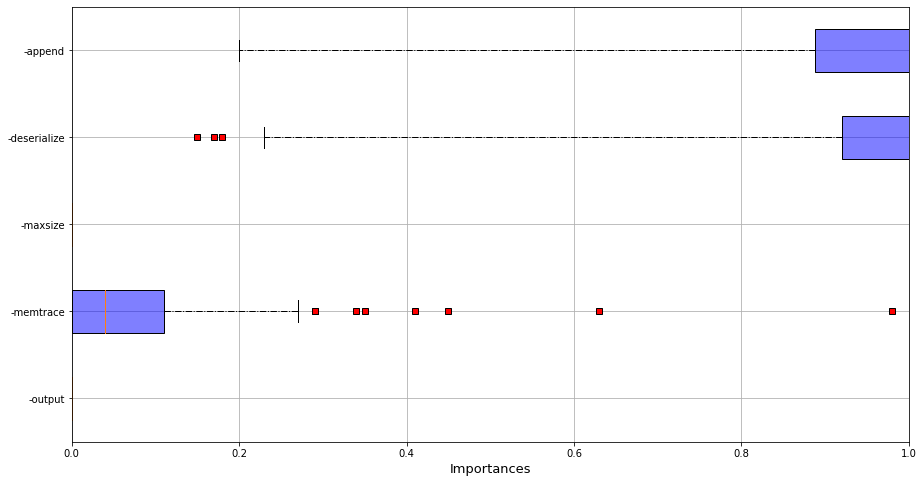

In [38]:
boxplot_imp("sqlite", "q5", xlim =[0,1], xname='Importances')

#### q6

[0.39960961 1.17096305 0.         0.34191183 0.        ]


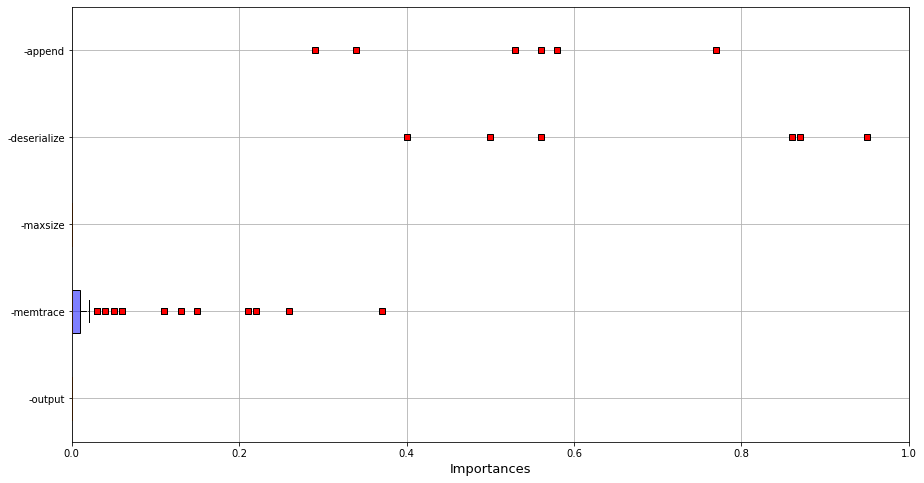

In [39]:
boxplot_imp("sqlite", "q6", xlim =[0,1], xname='Importances')

#### q7

[0.12960169 1.29369749 0.         0.08563079 0.        ]


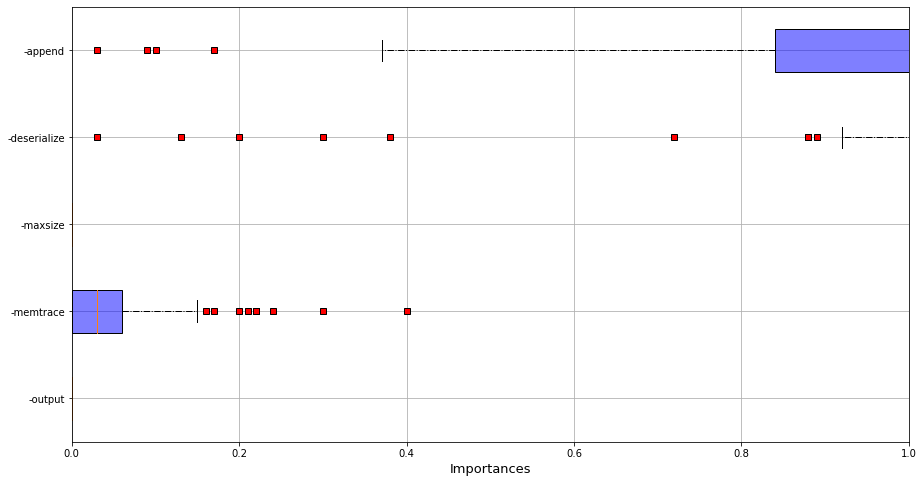

In [40]:
boxplot_imp("sqlite", "q7", xlim =[0,1], xname='Importances')

#### q8

[0.00208728 1.75669248 0.         0.00207285 0.        ]


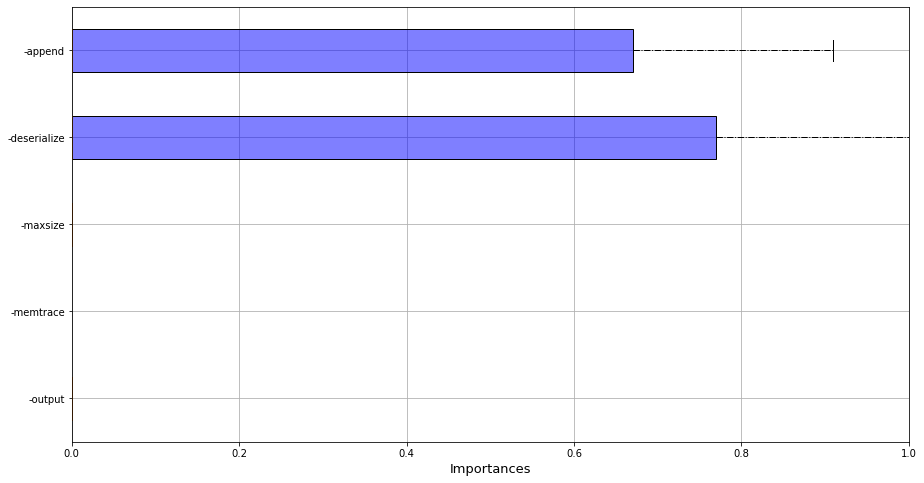

In [41]:
boxplot_imp("sqlite", "q8", xlim =[0,1], xname='Importances')

#### q9

[0.12387027 1.36629248 0.         0.17488723 0.        ]


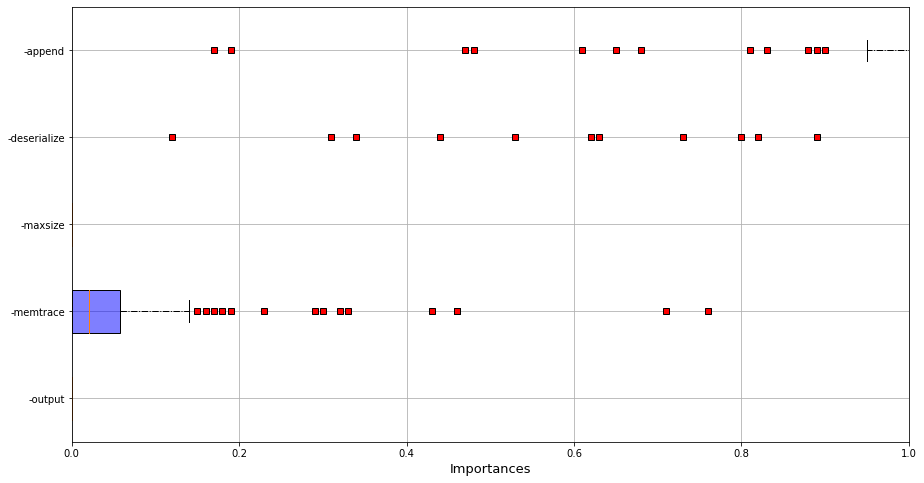

In [42]:
boxplot_imp("sqlite", "q9", xlim =[0,1], xname='Importances')

#### q10

[0.00711758 1.75593321 0.         0.00947005 0.        ]


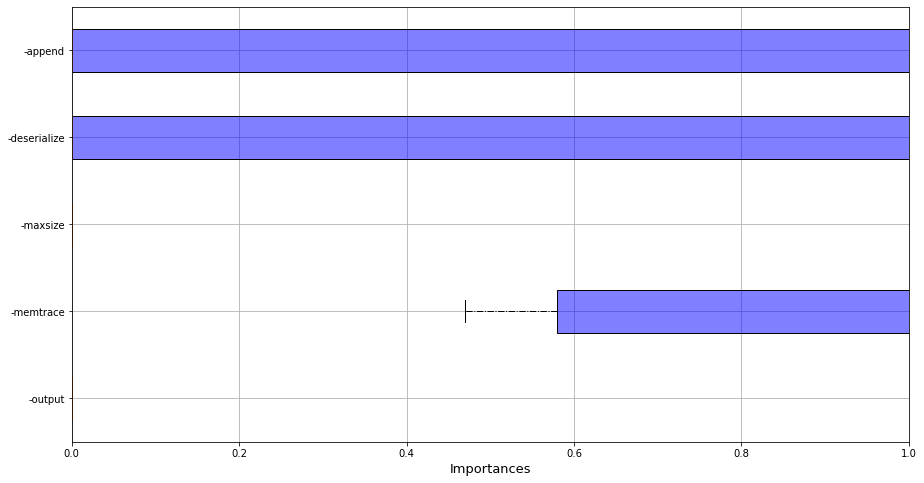

In [43]:
boxplot_imp("sqlite", "q10", xlim =[0,1], xname='Importances')

#### q11

[0.3059094  1.14343665 0.         0.28276566 0.        ]


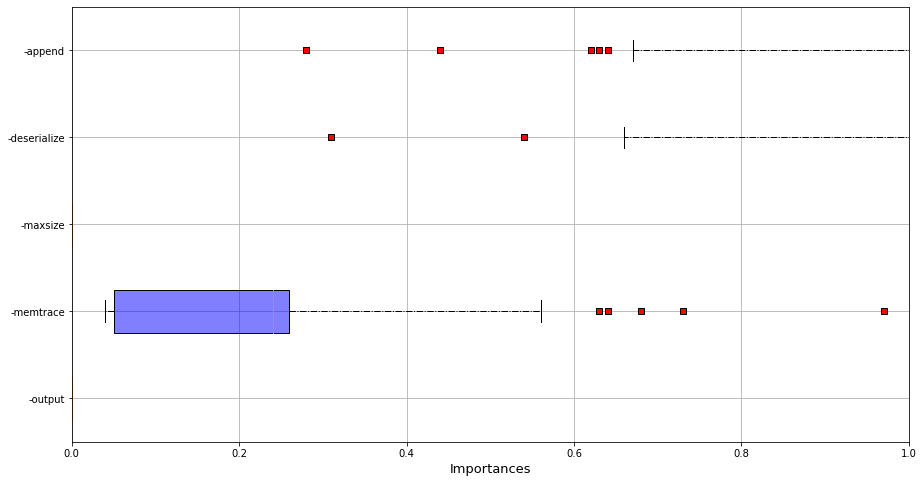

In [44]:
boxplot_imp("sqlite", "q11", xlim =[0,1], xname='Importances')

#### q12

[0.24042524 1.04296542 0.         0.23825702 0.        ]


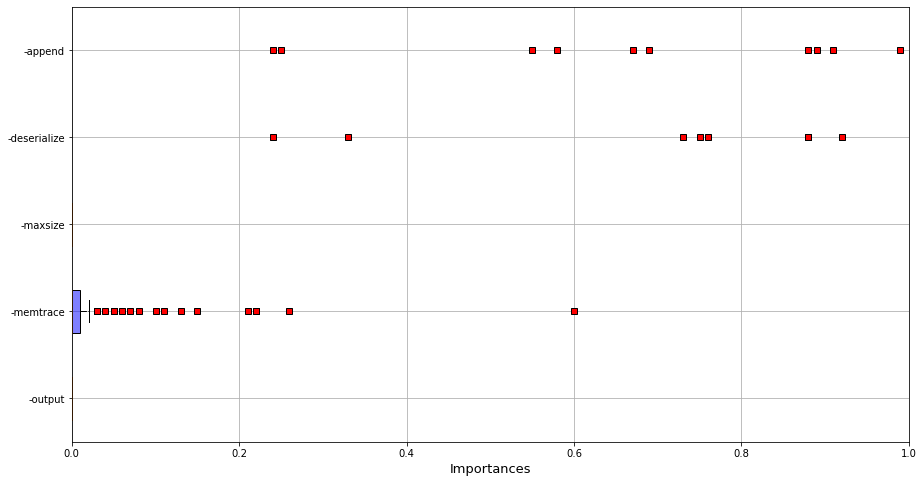

In [45]:
boxplot_imp("sqlite", "q12", xlim =[0,1], xname='Importances')

#### q13

[0.15535752 1.60938939 0.         0.17034009 0.        ]


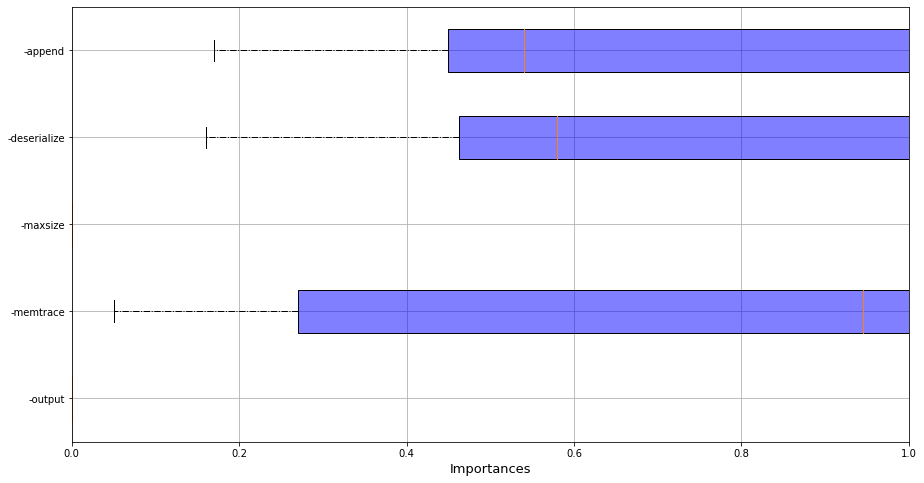

In [46]:
boxplot_imp("sqlite", "q13", xlim =[0,1], xname='Importances')

#### q14

[0.42584187 0.92834242 0.         0.30115936 0.        ]


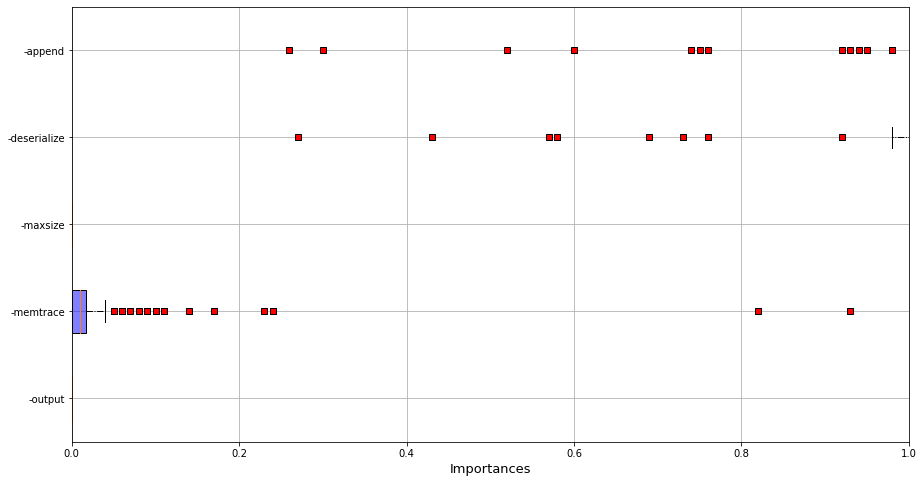

In [47]:
boxplot_imp("sqlite", "q14", xlim =[0,1], xname='Importances')

#### q15

[1.42775304 0.23601936 0.         1.11813299 0.        ]


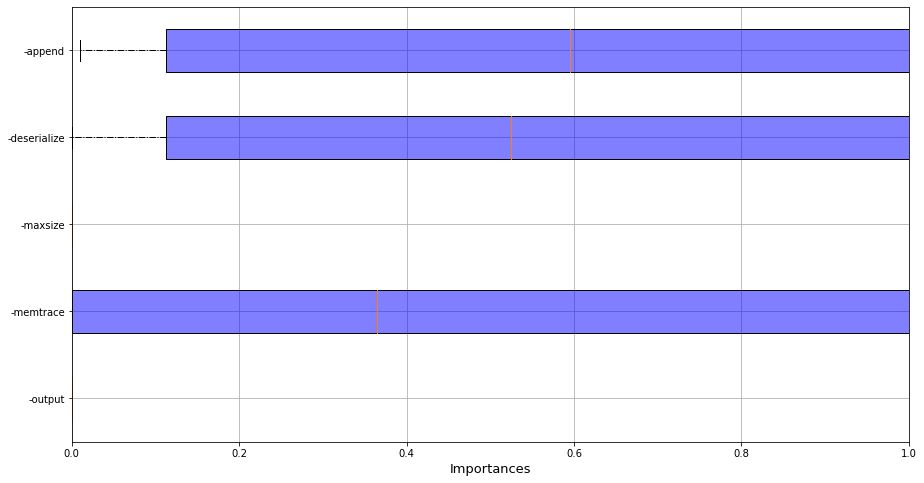

In [48]:
boxplot_imp("sqlite", "q15", xlim =[0,1], xname='Importances')

Between the different queries, the importances of options and the effect of coefficients vary.

SQLite is an input-sensitive software system.

### xz

#### size

[0.00000000e+00 6.15690330e-06 1.99963605e+00 1.51359109e-09]


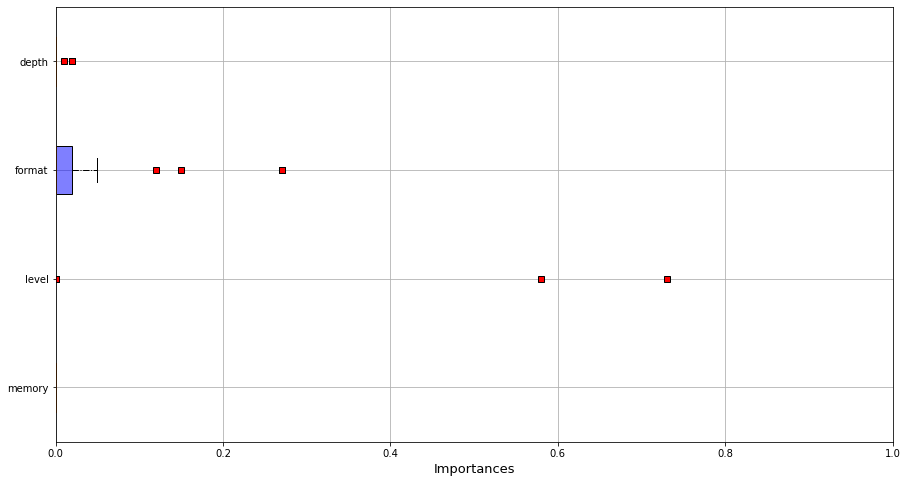

In [49]:
boxplot_imp("xz", "size", xlim =[0,1], xname='Importances')

Like gcc, another case of stability w.r.t. input sensitivity

The influential options remain the same, with the same effect.

#### time

[1.44414712e-04 3.47513647e-05 2.10996910e+00 5.53492350e-05]


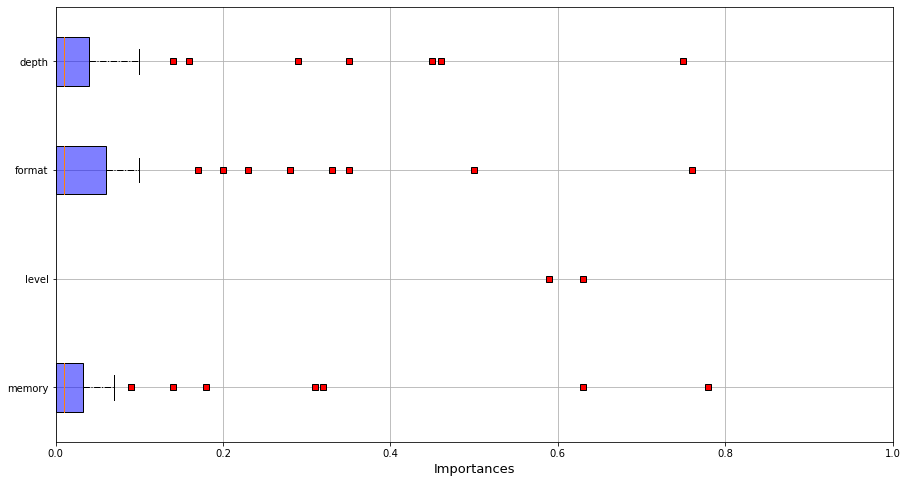

In [50]:
boxplot_imp("xz", "time", xlim =[0,1], xname='Importances')

Globally similar conclusion as for the size. 

The more stable the effect of options in RQ2, the more stable the distribution of performances in RQ1.

### x264

#### bitrate

[7.66784434e-02 1.25435430e-03 2.50586256e-04 5.22616387e-05
 1.14409280e-03 1.84987871e-01 1.24395566e-03 2.88397030e-06
 1.49731515e-03 1.92828063e-05 2.16734052e+00 2.83652682e-03
 1.95784592e-02 3.30785408e-02 1.77918799e-02 2.93929049e-01
 2.73234521e-02 0.00000000e+00 2.86391731e-02 2.37091997e-02
 6.77821939e-02 7.44197993e-02 0.00000000e+00 1.21416014e-02]


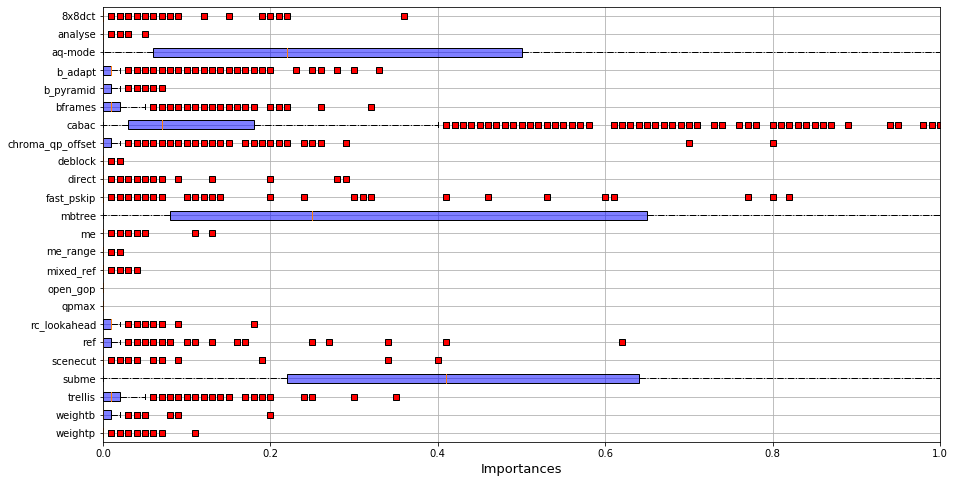

In [51]:
boxplot_imp("x264", "kbs", xlim =[0,1], xname='Importances')

x264 can encode different kinds of videos, such as an animation movie with many details, or a soccer game with large and monochromatic areas of grass. 
When encoding the soccer game, x264 can use those fixed green areas to reduce the amount of data encoded per second i.e. the bitrate. 
In other words, configuration options aggregating pixels (e.g. macro-block tree estimation `mbtree`) could: reduce the bitrate for the soccer game; increase the bitrate for the animation movie since nothing can be aggregated. 


This figures report on respectively the boxplots of configuration options' importances and effects when predicting x264's bitrate for all input videos. 

Three options are strongly influential for a majority of videos: 
`subme`, `mbtree` and `aq-mode`, but their importance can differ depending on input videos: for instance, the importance of subme is 0.83 for video 1365 and only 0.01 for 40. 
Because influential features vary with input videos for x264, performance models and approaches based on *feature selection* may not generalize well to all input videos. 


Most of the options have positive and negative coefficients; thus, the specific effects of options heavily depend on input videos. 
It is also true for influential options: mbtree can have positive and negative (influential) effects on the bitrate i.e. activating mbtree may be worth only for few input videos. 
The consequence is that one cannot reliably provide end-users with a unique x264 performance prediction model or a x264 default configuration whatever the input is.


#### frame encoded per second

[0.00494711 0.02451459 0.00447664 0.0117072  0.01148972 0.25049988
 0.00428851 0.00786688 0.04067842 0.00105782 0.00336301 0.00328142
 0.11784109 0.00111096 0.03561288 0.00339091 0.00269797 0.
 0.01838236 0.00135786 0.03892955 0.10820154 0.         0.04093633]


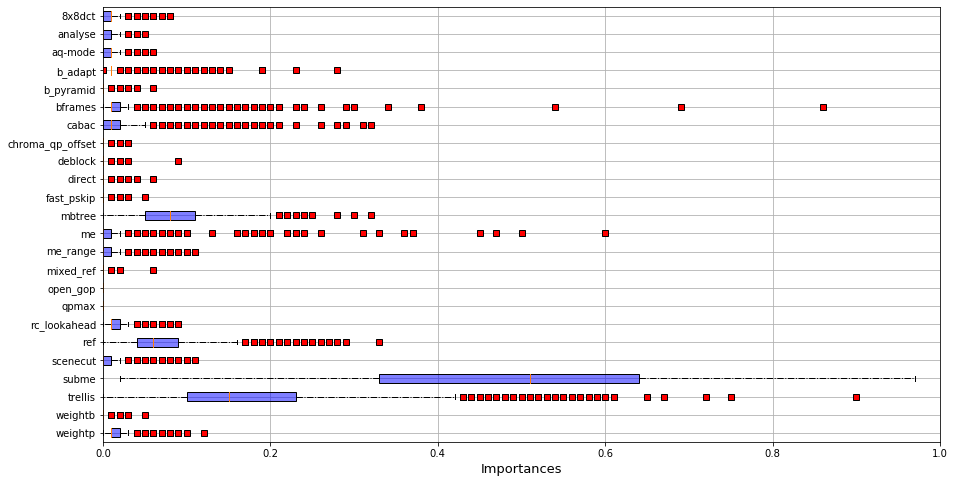

In [52]:
boxplot_imp("x264", "fps", xlim =[0,1], xname='Importances')

#### CPU usage

[0.00576572 0.21533253 0.00372529 0.00535718 0.1399263  0.76315325
 0.00455821 0.0073609  0.00921345 0.00124733 0.21158105 0.00240863
 0.00946312 0.00240619 0.00989946 0.04566214 0.00256145 0.
 0.00468137 0.00993074 0.04572251 0.22580884 0.         0.01070189]


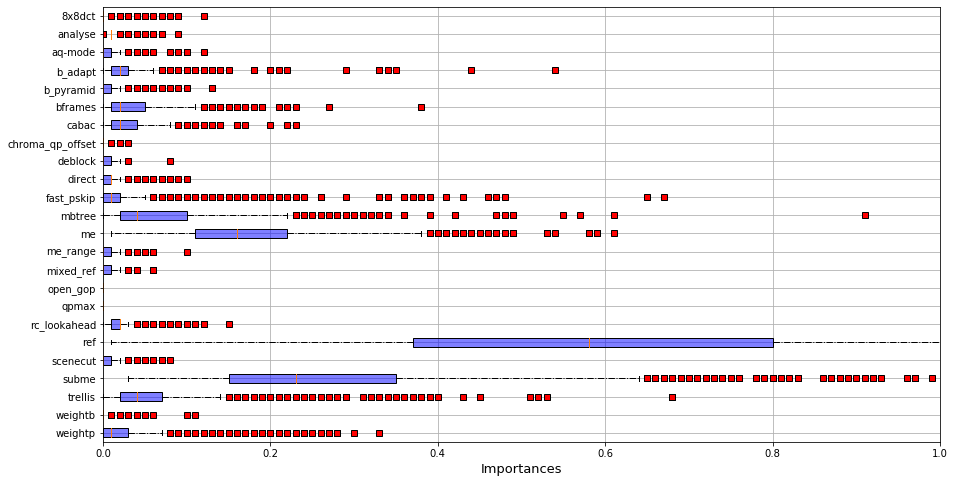

In [53]:
boxplot_imp("x264", "cpu", xlim =[0,1], xname='Importances')

#### Encoded size of video

[5.86851494e-02 3.01577643e-03 1.60009347e-04 3.08854309e-03
 6.72951207e-04 9.44518180e-02 8.61020615e-03 9.78601392e-05
 1.40103334e-05 2.75490200e-06 1.77682126e+00 1.84972107e-02
 1.72880885e-03 2.65444810e-02 2.20120898e-02 6.40489870e-01
 8.04661637e-03 0.00000000e+00 1.71887756e-02 4.12978869e-02
 6.48135388e-02 5.47101304e-02 0.00000000e+00 1.66501042e-02]


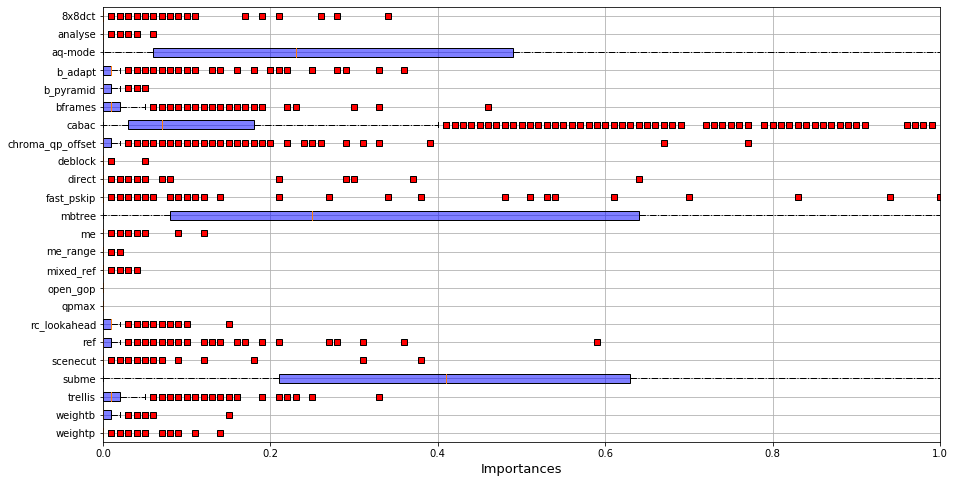

In [54]:
boxplot_imp("x264", "size", xlim =[0,1], xname='Importances')

#### Encoding time

[1.39717424e-03 2.05595490e-02 5.33458709e-04 3.44585903e-03
 9.65186512e-03 1.55278242e-01 3.42436727e-04 3.49128454e-03
 5.82214295e-02 8.67065835e-04 1.38743052e-02 7.84332756e-03
 3.79659442e-01 1.61584968e-04 9.09732164e-02 4.88240530e-03
 2.74393599e-04 0.00000000e+00 3.81865050e-03 2.51840916e-04
 2.60582658e-02 1.01267943e-02 0.00000000e+00 2.88371128e-03]


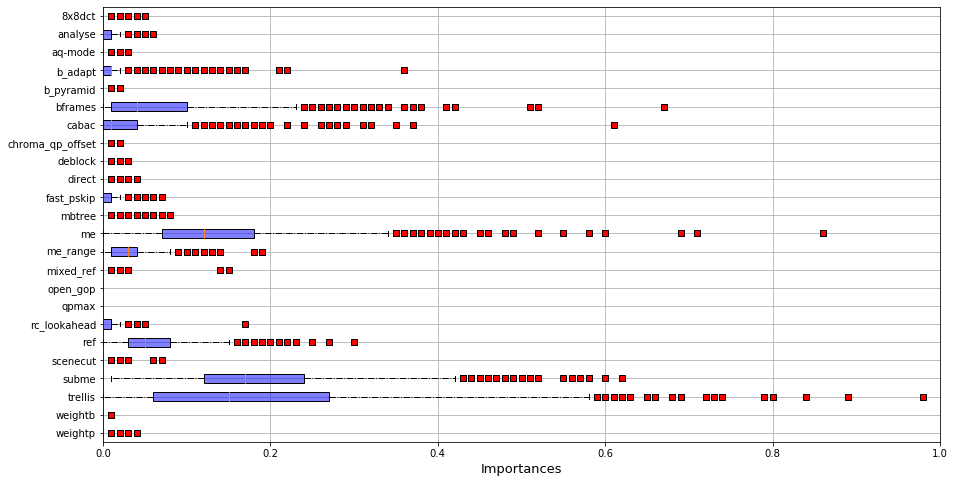

In [55]:
boxplot_imp("x264", "etime", xlim =[0,1], xname='Importances')